# Classic ML Methods on Original Imbalanced Data and Without Augmentation
## 1. Naive Bayes MultinomialNB 

In [15]:
import pandas as pd
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

#Load preprocessed data
ML_SPLITS_DIR = "../data/cleaned/ml-methods-splits/"
train_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "train_set.csv"), encoding="utf-8-sig")
test_df  = pd.read_csv(os.path.join(ML_SPLITS_DIR, "test_set.csv"),  encoding="utf-8-sig")

X_train = train_df['text_clean']
y_train = train_df['label']
X_test  = test_df['text_clean']
y_test  = test_df['label']

# Naïve Bayes Pipeline
# --- 2. Pipeline NB simple avec TF-IDF (tu peux adapter si tu combines features) ---
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2))),
    ("clf", MultinomialNB(alpha=1.0))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# --- 3. Évaluation standard ---
print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

# --- 4. Confusion matrix + comptages par classe réelle → prédite ---
labels = sorted(y_test.unique())  # ex: [0, 1, 2]
cm = confusion_matrix(y_test, y_pred, labels=labels)
print("Labels (vraies → prédits) = ", labels)
print("Confusion matrix (rows = true, cols = pred):\n", cm)

# Afficher de façon plus lisible
for i, true_label in enumerate(labels):
    for j, pred_label in enumerate(labels):
        print(f"Vrai = {true_label}, Prévu = {pred_label} : {cm[i, j]}")

# Exemple d’interprétation :
# “combien de négatifs (1) ont été classés positifs (2)” → cm[row_index_of_1, col_index_of_2]
# “combien de neutres (0) classés négatifs (1)” → cm[row_index_of_0, col_index_of_1], etc.

# --- 5. Tester quelques reviews manuelles (échantillons) ---
samples = [
    "Très mauvais gym, équipements sales 😠",       # negative
    "C'était correct, rien d'exceptionnel",         # neutral / maybe neutral
    "Super salle, coaches très sympa 👍⭐",         # positive
    "Pas terrible, je ne recommande pas",          # negative
    "Moyen, ni bon ni mauvais",                    # neutral
    "Excellent! Je reviendrai sans doute 🌟",      # positive
    "Horrible expérience, je suis déçu",           # negative
    "Ok pour commencer, mais pourrait être mieux", # neutral
]

preds = pipeline.predict(samples)
for s, p in zip(samples, preds):
    print("Texte:", s, "\t→ Prédiction:", p)



=== Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.2083    0.3448        24
           1     0.0000    0.0000    0.0000        10
           2     0.7100    1.0000    0.8304        71

    accuracy                         0.7238       105
   macro avg     0.5700    0.4028    0.3917       105
weighted avg     0.7087    0.7238    0.6403       105

Labels (vraies → prédits) =  [np.int64(0), np.int64(1), np.int64(2)]
Confusion matrix (rows = true, cols = pred):
 [[ 5  0 19]
 [ 0  0 10]
 [ 0  0 71]]
Vrai = 0, Prévu = 0 : 5
Vrai = 0, Prévu = 1 : 0
Vrai = 0, Prévu = 2 : 19
Vrai = 1, Prévu = 0 : 0
Vrai = 1, Prévu = 1 : 0
Vrai = 1, Prévu = 2 : 10
Vrai = 2, Prévu = 0 : 0
Vrai = 2, Prévu = 1 : 0
Vrai = 2, Prévu = 2 : 71
Texte: Très mauvais gym, équipements sales 😠 	→ Prédiction: 2
Texte: C'était correct, rien d'exceptionnel 	→ Prédiction: 2
Texte: Super salle, coaches très sympa 👍⭐ 	→ Prédiction: 2
Texte: Pas terrible, je ne recommand

c:\Users\OrdiOne\Desktop\customer_review_analysis\my_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\OrdiOne\Desktop\customer_review_analysis\my_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\OrdiOne\Desktop\customer_review_analysis\my_env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

## 2. Naive Bayes COMPLEMENTNB with the threshold adjustment fix 

Train: 431 samples
Test: 105 samples
Class distribution: Négatif=94, Neutre=39, Positif=298

STANDARD ComplementNB (Baseline)

Classification Report (Standard - Fails on Neutre):
              precision    recall  f1-score   support

     Négatif     0.5526    0.8750    0.6774        24
      Neutre     0.0000    0.0000    0.0000        10
     Positif     0.8788    0.8169    0.8467        71

    accuracy                         0.7524       105
   macro avg     0.4771    0.5640    0.5080       105
weighted avg     0.7205    0.7524    0.7274       105


ComplementNB WITH THRESHOLD ADJUSTMENT (Recommended)

Testing different thresholds for 'Neutre' class:
--------------------------------------------------
  Threshold 0.10: Neutre F1=0.125, Weighted F1=0.222
  Threshold 0.15: Neutre F1=0.143, Weighted F1=0.378
  Threshold 0.20: Neutre F1=0.145, Weighted F1=0.538
  Threshold 0.25: Neutre F1=0.216, Weighted F1=0.684
  Threshold 0.30: Neutre F1=0.167, Weighted F1=0.733
  Threshold 0.35: Ne

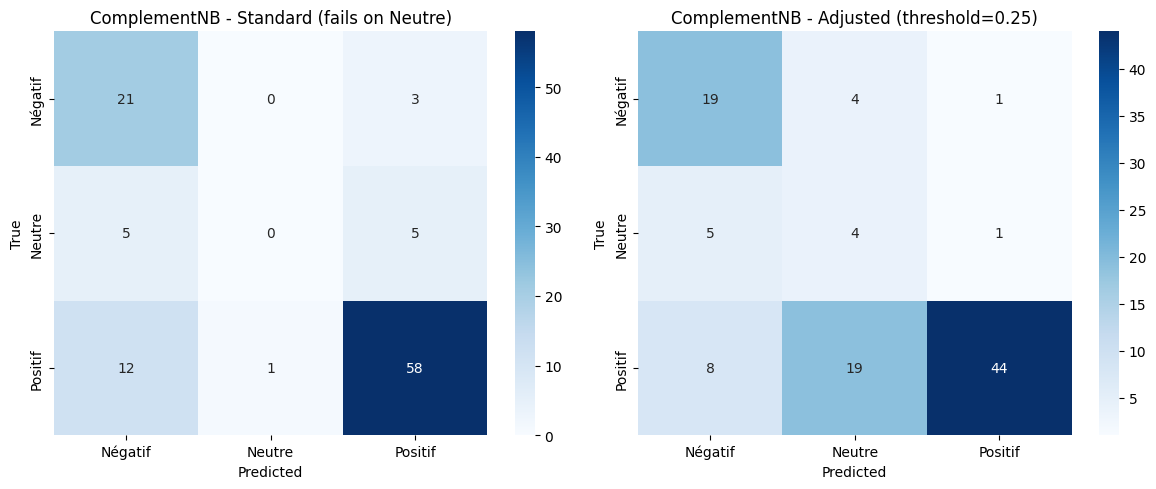


MANUAL TESTING WITH THRESHOLD-ADJUSTED MODEL

Predictions with probabilities:
--------------------------------------------------------------------------------
Text                                          Prediction   Probabilities (Nég/Neut/Pos)  
--------------------------------------------------------------------------------
Très mauvais gym, équipements sales 😠         Négatif      0.420/0.239/0.341             
C'était correct, rien d'exceptionnel          Neutre       0.304/0.279/0.417             
Super salle, coaches très sympa 👍⭐            Positif      0.116/0.137/0.747             
Pas terrible, je ne recommande pas            Négatif      0.578/0.240/0.182             
Moyen, ni bon ni mauvais                      Neutre       0.320/0.339/0.340             
Excellent! Je reviendrai sans doute 🌟         Positif      0.193/0.202/0.605             
Horrible expérience, je suis déçu             Neutre       0.363/0.299/0.338             
Ok pour commencer, mais pourrait être m

In [17]:
import pandas as pd
import os
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
ML_SPLITS_DIR = "../data/cleaned/ml-methods-splits/"
LABEL_NAMES = {0: "Négatif", 1: "Neutre", 2: "Positif"}

# Load data
train_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "train_set.csv"), encoding="utf-8-sig")
test_df = pd.read_csv(os.path.join(ML_SPLITS_DIR, "test_set.csv"), encoding="utf-8-sig")

X_train = train_df['text_clean']
y_train = train_df['label']
X_test = test_df['text_clean']
y_test = test_df['label']

print(f"Train: {len(X_train)} samples")
print(f"Test: {len(X_test)} samples")
print(f"Class distribution: Négatif={sum(y_train==0)}, Neutre={sum(y_train==1)}, Positif={sum(y_train==2)}")

# -----------------------------------------------------------------
# 1. TRAIN STANDARD COMPLEMENTNB (BASELINE)
# -----------------------------------------------------------------
print("\n" + "="*60)
print("STANDARD ComplementNB (Baseline)")
print("="*60)

pipeline_standard = Pipeline([
    ("tfidf", TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2))),
    ("clf", ComplementNB())
])

pipeline_standard.fit(X_train, y_train)
y_pred_standard = pipeline_standard.predict(X_test)

print("\nClassification Report (Standard - Fails on Neutre):")
print(classification_report(y_test, y_pred_standard, 
                           target_names=LABEL_NAMES.values(), 
                           digits=4, zero_division=0))

# -----------------------------------------------------------------
# 2. TRAIN WITH PROBABILITIES FOR THRESHOLD ADJUSTMENT
# -----------------------------------------------------------------
print("\n" + "="*60)
print("ComplementNB WITH THRESHOLD ADJUSTMENT (Recommended)")
print("="*60)

# We need the TF-IDF matrix for probability predictions
vectorizer = TfidfVectorizer(min_df=2, max_df=0.95, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train ComplementNB
cnb = ComplementNB()
cnb.fit(X_train_tfidf, y_train)

# Get probability predictions
y_proba = cnb.predict_proba(X_test_tfidf)

# Try different thresholds for Neutre class
thresholds = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35]
best_f1 = 0
best_threshold = 0
best_predictions = None

print("\nTesting different thresholds for 'Neutre' class:")
print("-" * 50)

for threshold in thresholds:
    # Custom prediction logic
    y_pred_custom = np.full(len(y_test), 2)  # Default to Positif
    
    # RULE 1: If probability for Neutre > threshold, predict Neutre
    neutre_mask = y_proba[:, 1] > threshold
    y_pred_custom[neutre_mask] = 1
    
    # RULE 2: If Négatif has clearly highest probability, predict Négatif
    # (Probability for Négatif > both other classes)
    negatif_best_mask = (y_proba[:, 0] > y_proba[:, 1]) & (y_proba[:, 0] > y_proba[:, 2])
    y_pred_custom[negatif_best_mask] = 0
    
    # Calculate F1 for Neutre specifically
    f1_neutre = f1_score(y_test == 1, y_pred_custom == 1, zero_division=0)
    
    print(f"  Threshold {threshold:.2f}: ", end="")
    print(f"Neutre F1={f1_neutre:.3f}", end="")
    
    # Calculate overall weighted F1 for comparison
    report = classification_report(y_test, y_pred_custom, 
                                  target_names=LABEL_NAMES.values(),
                                  output_dict=True, zero_division=0)
    weighted_f1 = report['weighted avg']['f1-score']
    print(f", Weighted F1={weighted_f1:.3f}")
    
    # Track best threshold
    if f1_neutre > best_f1:
        best_f1 = f1_neutre
        best_threshold = threshold
        best_predictions = y_pred_custom

# -----------------------------------------------------------------
# 3. FINAL RESULTS WITH BEST THRESHOLD
# -----------------------------------------------------------------
print(f"\n✅ BEST THRESHOLD: {best_threshold:.2f} (Neutre F1={best_f1:.3f})")
print("\nFinal Classification Report (with threshold adjustment):")
print(classification_report(y_test, best_predictions, 
                           target_names=LABEL_NAMES.values(), 
                           digits=4, zero_division=0))

# -----------------------------------------------------------------
# 4. CONFUSION MATRIX COMPARISON
# -----------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Standard vs Adjusted comparison
for idx, (y_pred, title) in enumerate([(y_pred_standard, "Standard (fails on Neutre)"), 
                                        (best_predictions, f"Adjusted (threshold={best_threshold:.2f})")]):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=LABEL_NAMES.values(),
                yticklabels=LABEL_NAMES.values())
    axes[idx].set_title(f'ComplementNB - {title}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------
# 5. MANUAL TESTING WITH ADJUSTED MODEL
# -----------------------------------------------------------------
print("\n" + "="*60)
print("MANUAL TESTING WITH THRESHOLD-ADJUSTED MODEL")
print("="*60)

samples = [
    "Très mauvais gym, équipements sales 😠",
    "C'était correct, rien d'exceptionnel",  # Should be Neutre
    "Super salle, coaches très sympa 👍⭐",
    "Pas terrible, je ne recommande pas",
    "Moyen, ni bon ni mauvais",  # Should be Neutre
    "Excellent! Je reviendrai sans doute 🌟",
    "Horrible expérience, je suis déçu",
    "Ok pour commencer, mais pourrait être mieux",  # Should be Neutre
    "Rien à signaler, tout est normal",  # New test: clearly neutral
]

# Transform samples using the same vectorizer
samples_tfidf = vectorizer.transform(samples)
samples_proba = cnb.predict_proba(samples_tfidf)

print("\nPredictions with probabilities:")
print("-" * 80)
print(f"{'Text':<45} {'Prediction':<12} {'Probabilities (Nég/Neut/Pos)':<30}")
print("-" * 80)

for i, sample in enumerate(samples):
    # Apply the same threshold logic
    if samples_proba[i, 1] > best_threshold:  # Neutre probability > threshold
        prediction = 1  # Neutre
    elif samples_proba[i, 0] > samples_proba[i, 1] and samples_proba[i, 0] > samples_proba[i, 2]:
        prediction = 0  # Négatif
    else:
        prediction = 2  # Positif
    
    probs_str = f"{samples_proba[i,0]:.3f}/{samples_proba[i,1]:.3f}/{samples_proba[i,2]:.3f}"
    print(f"{sample[:42]:<45} {LABEL_NAMES[prediction]:<12} {probs_str:<30}")

# -----------------------------------------------------------------
# 6. PERFORMANCE SUMMARY
# -----------------------------------------------------------------
print("\n" + "="*60)
print("PERFORMANCE SUMMARY: Standard vs Threshold-Adjusted")
print("="*60)

print(f"\n{'Metric':<15} {'Standard':<12} {'Adjusted':<12} {'Improvement':<12}")
print("-" * 51)

for label_id, label_name in LABEL_NAMES.items():
    if label_id in y_test.unique():
        # Standard model
        f1_standard = f1_score(y_test == label_id, y_pred_standard == label_id, zero_division=0)
        
        # Adjusted model  
        f1_adjusted = f1_score(y_test == label_id, best_predictions == label_id, zero_division=0)
        
        improvement = f1_adjusted - f1_standard
        
        print(f"{label_name:<15} {f1_standard:<12.3f} {f1_adjusted:<12.3f} {improvement:+.3f}")